This code uses functions from cwieder/sspa-in-metabolomics.

Repository URL: https://github.com/cwieder/sspa-in-metabolomics

Author(s): Wieder, Lai, and Ebbels (2022) 

License: GNU General Public License v3.0 (GPLv3)
The original code has been modified for this project.
The modified code follows the same GPLv3 license.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import os
import plotly.express as px
import seaborn as sns
import math
import scipy
import scipy.stats as ss

from scipy.stats import spearmanr
from sklearn.metrics.pairwise import nan_euclidean_distances 
import itertools
from itertools import tee
from itertools import permutations


import scipy as sp
from scipy import stats
import researchpy as rp
import scipy.stats as stat
import openpyxl

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,  RocCurveDisplay, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import scipy.stats as st
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error


In [ ]:
key_modules_genes = pd.read_csv(f'key_modules_genes.csv')
key_modules_genes.set_index('Unnamed: 0', inplace=True)

In [3]:
from gseapy import Biomart
bm = Biomart()

results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'])
results.tail()

,ensembl_gene_id,external_gene_name,entrezgene_id,go_id
475311,ENSG00000290825,DDX11L2,100287102,NaN
475312,ENSG00000290825,DDX11L2,727856,NaN
475313,ENSG00000290825,DDX11L2,84771,NaN
475314,ENSG00000227232,WASH7P,<NA>,NaN
475315,ENSG00000290826,NaN,<NA>,NaN


# reactome pathways

In [12]:
 def process_reactome(name, infile, organism):
        # Process CHEBI to reactome data
        dir = r"C:\Users\brsha\Thesis\metabolic genes dist"
        f = pd.read_csv(f"{dir}\{infile}", sep="\t", header=None)
        f.columns = ['ENSEMBL', 'pathway_ID', 'link', 'pathway_name', 'evidence_code', 'species']
        f_filt = f[f.species == organism]
        name_dict = dict(zip(f_filt['pathway_ID'], f_filt['pathway_name']))

        groups = f_filt.groupby(['pathway_ID'])['ENSEMBL'].apply(list).to_dict()
        df = pd.DataFrame.from_dict(groups, orient='index', dtype="object")

        pathways_df = df.dropna(axis=0, how='all', subset=df.columns.tolist()[1:])
        pathways = pathways_df.index.tolist()
        pathway_dict = {}

        for pathway in pathways:
            pathway_compounds = list(set(pathways_df.loc[pathway, :].tolist()))
            pathway_compounds = [str(i) for i in pathway_compounds if str(i) != "None"]

            cpds = pathway_compounds[1:]
            if len(cpds) > 1:
                pathway_dict[pathway] = cpds
        return pathway_dict, name_dict, pathways_df

In [238]:
# Load Reactome pathway dictionary
pathway_dict, pathway_names, pathways_df = process_reactome("R76", "Ensembl2Reactome_All_Levels.txt", "Homo sapiens")

# Remove large and uninformative pathways
remove_paths = ["R-HSA-1430728", "R-HSA-1643685", "R-HSA-382551"]
pathway_dict = {k: v for k, v in pathway_dict.items() if k not in remove_paths}


key_modules_data = key_modules_genes.iloc[:, :-2]
# Remove pathways not present in the dataset
compounds_present = key_modules_data.columns.tolist()
pathways_present = {k: v for k, v in pathway_dict.items() if len([i for i in compounds_present if i in v]) > 1}
print(len(pathways_present))
print(len(compounds_present))

879
1003


In [15]:
val_list = list(pathway_dict.values())
[i for i, lst in enumerate(val_list) if 'ENSG00000010610' in lst][0]

108

In [17]:
key_list = list(pathway_dict.keys())
val_list = list(pathway_dict.values())

position = [i for i, lst in enumerate(val_list) if 'ENSG00000010610' in lst][0]
print(key_list[position])


R-HSA-1280215


In [19]:
# list out keys and values separately
key_list = list(pathway_names.keys())
val_list = list(pathway_names.values())

position = key_list.index("R-HSA-1280215")
print(val_list[position])

Cytokine Signaling in Immune system


In [20]:
pathways_df['Pathway_name'] = pathways_df.index.map(pathway_names)

In [23]:
#all genes in pathways_present
all_pathway_mets = list(set([x for sublist in pathways_present.values() for x in sublist]))

md = key_modules_genes[["Group", "AGE"]]
key_modules_data_orig = key_modules_genes[key_modules_genes.columns.intersection(all_pathway_mets)]
key_modules_data_orig = pd.concat([key_modules_data_orig, md], axis=1)

key_modules_data_orig

,ENSG00000197971,ENSG00000197818,ENSG00000197361,ENSG00000196569,ENSG00000196470,ENSG00000188677,ENSG00000186480,ENSG00000185989,ENSG00000185760,ENSG00000182551,...,ENSG00000122862,ENSG00000122254,ENSG00000120889,ENSG00000120833,ENSG00000117394,ENSG00000116717,ENSG00000113368,ENSG00000135917,Group,AGE
GTEX-11EMC,-1.486007,0.942463,-1.260865,1.021034,0.341458,-0.271540,-0.624822,0.404978,0.713028,-1.909942,...,-0.812185,0.804741,-0.045281,-0.553753,0.279047,-0.225015,-0.483999,1.687922,old,60.0
GTEX-11GS4,-0.455757,0.105058,0.351689,-1.444680,0.203571,0.914300,0.475690,-1.274745,-0.958620,0.397989,...,0.535089,-0.347366,1.230357,-0.648118,-0.570422,-0.057022,-0.719253,-0.297644,old,60.0
GTEX-11GSO,-0.571481,2.234688,-1.263283,-0.324241,0.991913,-0.116604,-0.093312,1.449244,1.071746,0.836280,...,-0.259460,1.887318,-0.674426,-0.635149,-0.602942,-0.917219,0.419057,-0.281790,old,60.0
GTEX-11OF3,0.231102,-0.046186,0.737194,-1.144417,-0.960339,0.761867,-0.290200,0.567676,-1.442245,1.333931,...,0.215573,-0.433508,-0.917911,-1.711201,0.942315,-0.292283,-0.998947,-0.497928,old,60.0
GTEX-11ONC,-0.188466,1.123729,-1.115462,0.139937,0.625903,-1.095502,0.304555,0.431398,1.050609,-1.300595,...,0.105141,0.594795,0.424053,0.105315,2.204590,0.296301,-0.078172,-0.025777,old,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-T6MN,2.023956,0.187911,-0.313056,-0.106783,-1.105277,0.144457,-0.619772,-0.092767,-0.806934,-0.394099,...,-0.715091,0.065873,-0.024905,-0.474760,2.699850,-1.848863,1.848208,-0.407446,young,50.0
GTEX-WL46,0.921074,-1.155905,-0.184872,0.001594,-0.568484,0.812830,-1.265807,0.389793,-1.815073,0.578607,...,-0.409066,-0.679098,-1.654513,-0.680592,-0.778920,0.041885,0.372747,-0.801647,young,50.0
GTEX-YFC4,0.806960,0.000847,-1.133575,-2.002841,-0.021293,0.462469,-0.927885,0.705992,-0.806310,0.397989,...,-0.075211,-1.220887,0.249794,0.216060,-0.271122,1.649149,0.724743,-0.016948,young,40.0
GTEX-ZAK1,0.162599,-0.799299,-0.126880,-1.256150,0.188891,1.962869,0.688816,-1.290315,1.026534,0.085101,...,0.540346,-1.833345,-1.188015,-0.193064,-1.148485,-0.317393,0.389136,-0.329785,young,50.0


In [24]:
from sklearn.decomposition import PCA, KernelPCA
def kpca_res(mat, pathways):
    pathway_matrices = []
    pathway_ids = []
    for pathway, compounds in pathways.items():
        single_pathway_matrix = mat.drop(mat.columns.difference(compounds), axis=1)
        if single_pathway_matrix.shape[1] >= 1:
            pathway_matrices.append(single_pathway_matrix.values)
            pathway_ids.append(pathway)

    scores = []
    for n, m in enumerate(pathway_matrices):
        kpca = KernelPCA(n_components=2, kernel="rbf")
        new_data = kpca.fit_transform(m)
        scores.append(new_data[:, 0])
    scores_df = pd.DataFrame(scores, columns=mat.index, index=pathways.keys())
    return scores_df

In [57]:
scores = kpca_res(key_modules_genes.iloc[:, :-2], pathways_present).T
scores

,R-HSA-1059683,R-HSA-109581,R-HSA-109582,R-HSA-109606,R-HSA-109704,R-HSA-110056,R-HSA-111885,R-HSA-112040,R-HSA-112043,R-HSA-112310,...,R-HSA-9827857,R-HSA-983168,R-HSA-983169,R-HSA-983189,R-HSA-983231,R-HSA-983695,R-HSA-983705,R-HSA-983712,R-HSA-991365,R-HSA-997272
GTEX-11EMC,0.287018,-0.540259,-0.436483,-0.336782,0.340985,0.239668,-0.484925,-0.436819,-0.436819,-0.331528,...,-0.439694,-0.378101,0.372513,0.160110,-0.447270,-0.501613,-0.504289,-0.514922,0.063352,0.063352
GTEX-11GS4,-0.315471,0.206532,0.243264,0.458281,-0.180666,-0.307933,0.352001,0.447372,0.447372,0.520562,...,-0.625446,0.064576,-0.051784,0.026021,0.003735,0.557035,0.511542,0.074877,0.058103,0.058103
GTEX-11GSO,-0.503342,-0.355796,-0.140042,-0.071204,-0.167818,-0.441812,-0.418941,-0.618569,-0.618569,-0.237367,...,0.586722,-0.417570,0.358802,0.703844,-0.067115,-0.344858,-0.283516,-0.289738,0.271999,0.271999
GTEX-11OF3,-0.379908,0.494926,0.340453,0.654286,-0.386999,-0.404909,0.115414,0.052731,0.052731,0.386236,...,0.387763,0.472218,-0.345164,-0.213141,0.338389,0.314851,0.322085,0.040663,-0.356317,-0.356317
GTEX-11ONC,-0.382400,0.079870,-0.019444,0.251875,0.014706,-0.169057,-0.295113,-0.319392,-0.319392,0.007832,...,0.229559,-0.014925,0.019780,0.048506,-0.138920,0.044997,0.016425,-0.171878,0.331492,0.331492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-T6MN,-0.302846,0.263929,0.489850,0.471202,-0.024192,-0.328208,0.579853,0.646606,0.646606,0.588349,...,-0.014303,0.301691,-0.360423,-0.402981,0.490196,0.482776,0.461121,0.497356,-0.523948,-0.523948
GTEX-WL46,-0.473287,0.496122,0.358599,0.620657,-0.433311,-0.497137,0.496243,0.543034,0.543034,0.646088,...,0.064040,0.322861,-0.440644,0.244878,0.262140,0.518272,0.448274,0.542242,-0.391909,-0.391909
GTEX-YFC4,-0.136497,0.386826,0.438181,0.450552,-0.270806,-0.143823,0.598136,0.683958,0.683958,0.553552,...,-0.207348,0.191557,-0.319486,-0.227087,0.380026,0.696500,0.642305,0.469439,-0.506388,-0.506388
GTEX-ZAK1,0.001778,0.364146,0.085799,0.450597,-0.205749,0.028892,0.073706,0.452929,0.452929,0.239997,...,-0.056047,0.176847,-0.134102,-0.401256,0.344065,0.353400,0.350444,0.273279,0.013350,0.013350


In [59]:
import statsmodels.api as sm

def t_tests(matrix, classes, multiple_correction_method, testtype="ttest"):
    metabolites = matrix.columns.tolist()
    matrix['Target'] = pd.factorize(classes)[0]
    disease = matrix.loc[matrix["Target"] == 0]
    disease.drop(['Target'], axis=1, inplace=True)
    ctrl = matrix.loc[matrix["Target"] != 0]
    ctrl.drop(['Target'], axis=1, inplace=True)
    if testtype == "mwu":
        pvalues = stats.mannwhitneyu(disease, ctrl, axis=0)[1]
    else:
        pvalues = stats.ttest_ind(disease, ctrl)[1]
        
    print(len(pvalues))
    padj = sm.stats.multipletests(pvalues, 0.05, method=multiple_correction_method)
    results = pd.DataFrame(zip(metabolites, pvalues, padj[1]),
                           columns=["Pathway", "P-value", "P-adjust"])
    return results

In [60]:
de_res_path = t_tests(scores, key_modules_genes["Group"], "fdr_bh")
de_res_path

879


<ipython-input-59-f1442aa4e613>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease.drop(['Target'], axis=1, inplace=True)
<ipython-input-59-f1442aa4e613>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl.drop(['Target'], axis=1, inplace=True)


,Pathway,P-value,P-adjust
0,R-HSA-1059683,0.771302,0.813385
1,R-HSA-109581,0.328788,0.534053
2,R-HSA-109582,0.235393,0.461071
3,R-HSA-109606,0.279593,0.501662
4,R-HSA-109704,0.515459,0.639053
...,...,...,...
874,R-HSA-983695,0.075721,0.409931
875,R-HSA-983705,0.134694,0.413725
876,R-HSA-983712,0.114190,0.409931
877,R-HSA-991365,0.036913,0.409931


In [61]:
top50paths = de_res_path.sort_values(by="P-adjust")["Pathway"].tolist()[0:50]
scores = scores.loc[:, top50paths]
scores_df = pd.concat([scores, key_modules_genes[["Group"]]], axis=1)

colours = sns.color_palette("tab10")

group_dict = {"young":"lightseagreen", "old":"lightcoral"}
#row_cols = dict(zip(key_modules_genes.index, [colors_dict[i] for i in key_modules_genes["AGE"]]))
row_cols2 = dict(zip(key_modules_genes.index, [group_dict[i] for i in key_modules_genes["Group"]]))

print(group_dict)

{'young': 'lightseagreen', 'old': 'lightcoral'}


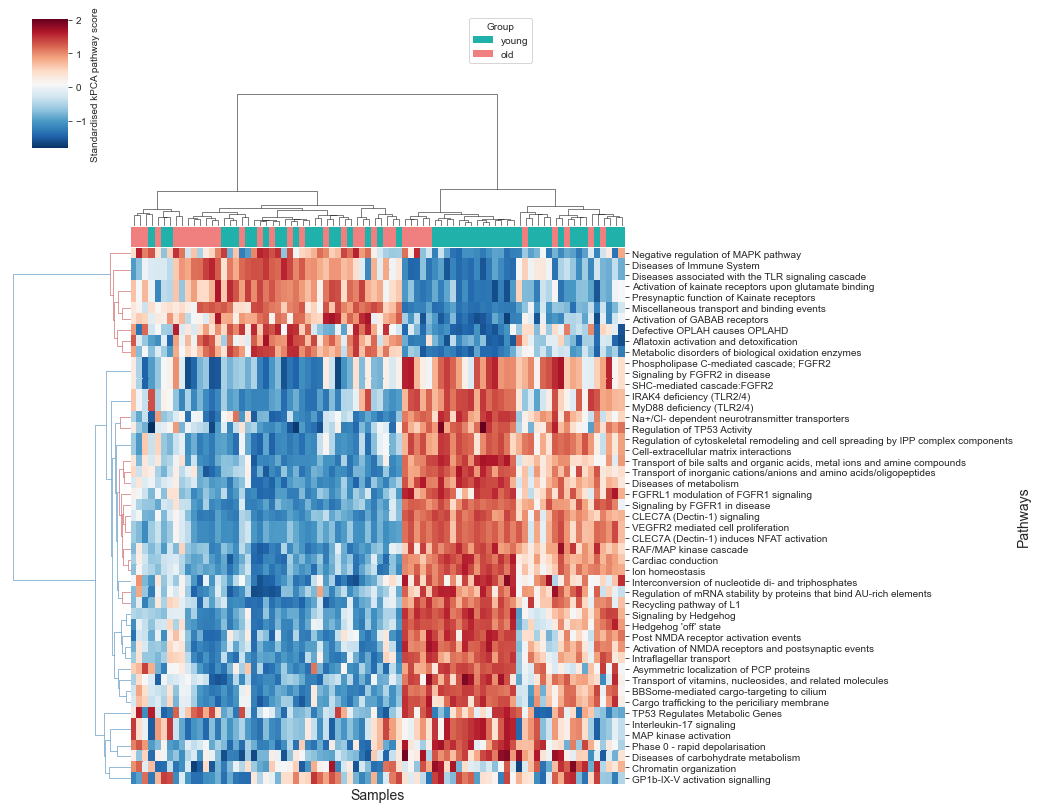

In [62]:
#col_cols = key_modules_genes.index.map(row_cols)
col_cols2 = key_modules_genes.index.map(row_cols2)
sns.set_style("ticks")
g = sns.clustermap(scores_df.iloc[:, :-2].T,
               z_score=0,
               col_colors=[col_cols2],
               method="ward",
              yticklabels=True,
              xticklabels=False,
                  cmap="RdBu_r",
                  cbar_kws={'label': 'Standardised kPCA pathway score'},
                  cbar_pos=(0.05, 0.9, 0.05, 0.18),
                  tree_kws={'colors':'black'})
dendro_cols = sns.color_palette("RdBu_r")
g.ax_heatmap.set_xlabel("Samples", fontsize=14)
g.ax_heatmap.set_ylabel("Pathways", fontsize=14)

top50_dict = dict(zip(range(0, 50), top50paths))
top50_map = [top50_dict[i] for i in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_yticklabels([pathway_names[i] for i in top50_map])

# legends 
from matplotlib.pyplot import gcf

age = ["old", "young"]
#group_dict = {"young":"red", "old":"green"}
dendro_cols = sns.color_palette("RdBu_r")
for label in list(set(key_modules_genes["Group"])):
    g.ax_row_dendrogram.bar(0, 0, color=group_dict[label], label=label, linewidth=0)

l2 = g.ax_row_dendrogram.legend(title='Group', loc="center", ncol=1, bbox_to_anchor=(0.7, 1.05), bbox_transform=gcf().transFigure)

# set dendrogram colours
for l in g.ax_row_dendrogram.collections:
    l.set_edgecolor([dendro_cols[5] for i in range(0, 25)] + [dendro_cols[0] for i in range(0, 25)] )
    

plt.savefig(f"plots/ssGSEA_Clustered_heatmap.png", bbox_inches='tight', dpi=300)


plt.show()

# single sample pathway analysis

In [25]:
#pip install WinPython
#pip install rpy2==3.5.11

# user defined R installation
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.3.1' #path to your R installation
os.environ['R_USER'] = r'C:\Users\brsha\anaconda3\Lib\site-packages\rpy2' #path depends on where you installed Python.

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import conversion, default_converter

with conversion.localconverter(default_converter):
    gsva_r = importr('GSVA')
    print(gsva_r)

rpy2.robjects.packages.Package as a <module 'GSVA'>


In [239]:
def ssgsea_results(mat, pathways):
    with conversion.localconverter(default_converter):
        base = importr('base')
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_mat = ro.conversion.py2rpy(mat.iloc[:, :-1].T)
        r_mat = base.as_matrix(r_mat)  # abundance matrix
        row_vec = base.as_character(mat.columns[:-1].tolist())
        r_mat.rownames = row_vec
        r_list = ro.ListVector(pathways)  # pathways
        gsva_r = importr('GSVA')
        gsva_res = gsva_r.gsva(r_mat, r_list, method="ssgsea")
        with localconverter(ro.default_converter + pandas2ri.converter):
            gsva_df = ro.conversion.rpy2py(gsva_res)
        ssgsea_scores = pd.DataFrame(gsva_df, index=pathways.keys(), columns=mat.iloc[:, :-1].index.tolist())
        return ssgsea_scores


In [247]:
# pathway level
scores_gsea = ssgsea_results(key_modules_data_orig.iloc[:, :-2], pathways_present).T
de_res_path_gsea = t_tests(scores_gsea, key_modules_data_orig["Group"], "fdr_bh")
top50paths_gsea = de_res_path_gsea.sort_values(by="P-adjust")["Pathway"].tolist()[0:50]
scores_gsea = scores_gsea.loc[:, top50paths_gsea]
scores_df_gsea = pd.concat([scores_gsea, key_modules_data_orig[["Group", "AGE"]]], axis=1)

skf_p = StratifiedKFold(n_splits=3)
X_p = scores_df_gsea.iloc[:, :-2].to_numpy()
y_p = labels
clf_p = RandomForestClassifier()
print(cross_val_score(clf_p, X_p, y_p, cv=skf_p, scoring="roc_auc"))

C:\Users\brsha\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Estimating ssGSEA scores for 879 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
879


<ipython-input-59-f1442aa4e613>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease.drop(['Target'], axis=1, inplace=True)
<ipython-input-59-f1442aa4e613>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl.drop(['Target'], axis=1, inplace=True)


[0.75520833 0.67897727 0.84943182]


## Random Forest with ssGSEA

In [248]:
# met level with RF  

aging_classification (key_modules_genes, 'RF')

labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X = key_modules_genes_selected.iloc[:, :-2].to_numpy()
y = labels

base_fpr = np.linspace(0, 1, 101)
roc_all = []
tprs = []
aurocs = []

accs, precs, recs, f1s = [], [], [], []


# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier()

    random_grid = { 
    'n_estimators': [100, 150, 200, 250, 300] ,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 12],
    'criterion' :['gini', 'entropy']
}
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    model_hyper = RandomizedSearchCV(model,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = model_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   
    fpr, tpr, _ = roc_curve(y_test, model_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    aurocs.append(roc_auc_score(y_test, model_hyper.predict_proba(X_test)[:, 1]))
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc = auc(base_fpr, mean_tprs)
print(f'Mean AUC: {np.mean(roc_auc)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.647, est=0.911, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
>acc=0.882, est=0.902, cfg={'n_estimators': 300, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
>acc=0.688, est=0.927, cfg={'n_estimators': 300, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
>acc=0.875, est=0.877, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
>acc=0.875, est=0.872, cfg={'n_estimators': 100, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}
0.88 accuracy with a standard deviation of 0.07
Mean AUC: 0.8728962222222222, Mean Accuracy: 0.7933823529411764, Mean Precision: 0.7674458874458875, Mean Recall: 0.96, Mean F1: 0.8483399209486165
Accuracy: 0.793 (0.104)


>acc=0.706, est=0.795, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
>acc=0.824, est=0.781, cfg={'n_estimators': 100, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}
>acc=0.812, est=0.785, cfg={'n_estimators': 300, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
>acc=0.688, est=0.863, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
>acc=0.812, est=0.802, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
0.88 accuracy with a standard deviation of 0.07
Mean AUC: 0.813714888888889, Mean Accuracy: 0.7683823529411764, Mean Precision: 0.7868686868686868, Mean Recall: 0.8333333333333334, Mean F1: 0.8048356184579095
Accuracy: 0.768 (0.059)


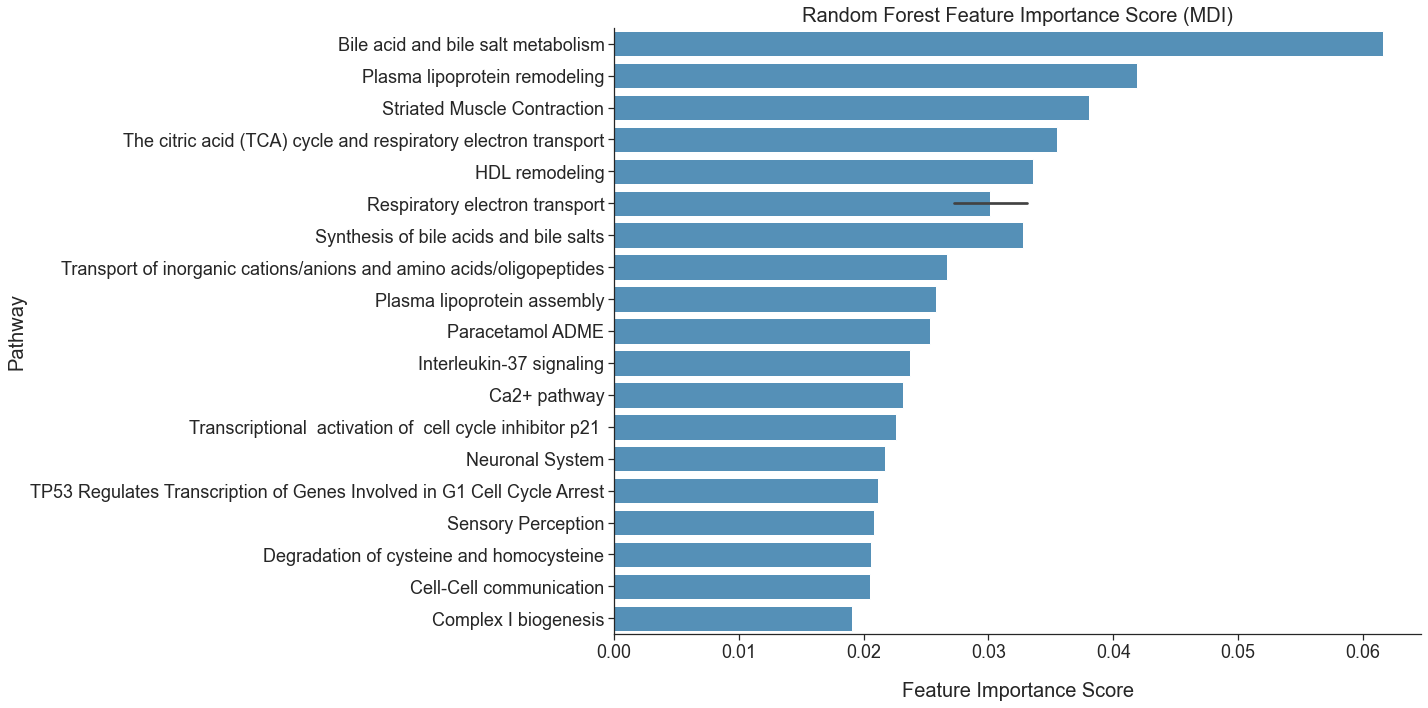

In [274]:
# pathway level with RF

aging_classification (scores_df_gsea, key_modules_genes, 'RF')

labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X = scores_df_gsea.iloc[:, :-2].to_numpy()
y = labels

base_fpr_p = np.linspace(0, 1, 101)
roc_all_p = []
tprs_p = []
aurocs_p = []

accs, precs, recs, f1s = [], [], [], []

importances_per_fold = []

# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    model = RandomForestClassifier()

    random_grid = { 
    'n_estimators': [100, 150, 200, 250, 300] ,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 12],
    'criterion' :['gini', 'entropy']
}
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    model_hyper = RandomizedSearchCV(model,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = model_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   
    fpr, tpr, _ = roc_curve(y_test, model_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr_p, fpr, tpr)
    tpr[0] = 0.0
    tprs_p.append(tpr)
    aurocs_p.append(roc_auc_score(y_test, model_hyper.predict_proba(X_test)[:, 1]))
    
    importances_per_fold.append(best_model.feature_importances_)

tprs_p = np.array(tprs_p)
mean_tprs_p = tprs_p.mean(axis=0)
std_p = tprs_p.std(axis=0)
tprs_upper_p = np.minimum(mean_tprs_p + std_p, 1)
tprs_lower_p = mean_tprs_p - std_p
                         

print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc = auc(base_fpr_p, mean_tprs_p)
print(f'Mean AUC: {np.mean(roc_auc)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))


av_importances = np.mean(importances_per_fold, axis = 0)
feat_importances = pd.DataFrame(av_importances, index = scores_df_gsea.iloc[:, :-2].columns, columns=["Importance"])
feat_importances["Name"] = feat_importances.index.map(pathway_names)
feat_importances["Name"] = feat_importances["Name"].str.split(',').str[0]
feat_importances.set_index('Name', inplace = True)
feat_importances = feat_importances.sort_values(by='Importance', ascending=False).iloc[:20]


#Barplot
plt.figure(figsize = (20,10))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=feat_importances['Importance'], y=feat_importances.index.to_list(), color = '#4594c7')
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=20)
plt.xlabel('Feature Importance Score', fontsize=20,labelpad=20)
plt.ylabel('Pathway', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"plots/RF_pathway_importance.png", dpi=300)


#feat_importances.plot(kind='bar', figsize=(8,6))


## XGboost with ssGSEA

In [201]:
# pathway level with XGB

labels = pd.factorize(key_modules_genes["Group"])[0]



skf = StratifiedKFold(n_splits=5)
X = scores_df_gsea.iloc[:, :-2].to_numpy()
y = labels

base_fpr_p_xgb = np.linspace(0, 1, 101)
roc_all_p_xgb = []
tprs_p_xgb = []
aurocs_p_xgb = []


accs, precs, recs, f1s = [], [], [], []


# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    xgb_tune = xgb.XGBClassifier()

    
    n_estimators = [100, 150, 200, 250, 300] 
    max_depth = [6, 8, 10, 12]
    #min_child_weight = [1, 2, 4, 8] 
    learning_rate = [.3, .1, .03, .01, .003, .001]
    subsample = [.8, .9, 1.0]
    colsample = [.8, .9, 1.0]

    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate':learning_rate,
                    #"min_child_weight": min_child_weight,
                    "colsample_bytree": colsample,
                    "subsample": subsample}
    
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = xgb_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
 
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   
    fpr, tpr, _ = roc_curve(y_test, xgb_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr_p_xgb, fpr, tpr)
    tpr[0] = 0.0
    tprs_p_xgb.append(tpr)
    aurocs_p.append(roc_auc_score(y_test, xgb_hyper.predict_proba(X_test)[:, 1]))

tprs_p_xgb = np.array(tprs_p)
mean_tprs_p_xgb = tprs_p_xgb.mean(axis=0)
std_p_xgb = tprs_p_xgb.std(axis=0)
tprs_upper_p_xgb = np.minimum(mean_tprs_p_xgb + std_p_xgb, 1)
tprs_lower_p_xgb = mean_tprs_p_xgb - std_p_xgb
           
print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc_p_xgb = auc(base_fpr_p_xgb, mean_tprs_p_xgb)
print(f'Mean AUC: {np.mean(roc_auc_p_xgb)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.765, est=0.722, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.882, est=0.710, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
>acc=0.625, est=0.783, cfg={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
>acc=0.750, est=0.840, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.688, est=0.745, cfg={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
0.89 accuracy with a standard deviation of 0.08
Mean AUC: 0.8252431111111111, Mean Accuracy: 0.7419117647058824, Mean Precision: 0.7790870240870241, Mean Recall: 0.8133333333333332, Mean F1: 0.788946608946609
Accuracy: 0.742 (0.086)


In [181]:
# met level with xgb  

labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X = key_modules_genes_selected.iloc[:, :-2].to_numpy()
y = labels

base_fpr_xgb = np.linspace(0, 1, 101)
roc_all_xgb = []
tprs_xgb = []
aurocs_xgb = []

accs, precs, recs, f1s = [], [], [], []


# configure the cross-validation procedure
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in skf_outer.split(X,y):
 # split data
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # configure the cross-validation procedure
    skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    # define the model
    xgb_tune = xgb.XGBClassifier()

    
    n_estimators = [100, 150, 200, 250, 300] 
    max_depth = [6, 8, 10, 12]
    #min_child_weight = [1, 2, 4, 8] 
    learning_rate = [.3, .1, .03, .01, .003, .001]
    subsample = [.8, .9, 1.0]
    colsample = [.8, .9, 1.0]

    random_grid = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate':learning_rate,
                    #"min_child_weight": min_child_weight,
                    "colsample_bytree": colsample,
                    "subsample": subsample}
    
    
    
     
    scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    # define search
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                   n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
    # execute search
    result = xgb_hyper.fit(X_train, y_train)

    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
                           
    accs.append(accuracy_score(y_test, yhat))
    precs.append(precision_score(y_test, yhat))
    recs.append(recall_score(y_test, yhat))
    f1s.append(f1_score(y_test, yhat))   

    fpr, tpr, _ = roc_curve(y_test, xgb_hyper.predict_proba(X_test)[:,1])   
    tpr = np.interp(base_fpr_xgb, fpr, tpr)
    tpr[0] = 0.0
    tprs_xgb.append(tpr)
    aurocs.append(roc_auc_score(y_test, xgb_hyper.predict_proba(X_test)[:, 1]))
        
tprs_xgb = np.array(tprs_xgb)
mean_tprs_xgb = tprs_xgb.mean(axis=0)
std_xgb = tprs_xgb.std(axis=0)
tprs_upper_xgb = np.minimum(mean_tprs_xgb + std_xgb, 1)
tprs_lower_xgb = mean_tprs_xgb - std_xgb

print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
roc_auc_xgb = auc(base_fpr_xgb, mean_tprs_xgb)
print(f'Mean AUC: {np.mean(roc_auc_xgb)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

#plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.706, est=0.786, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.647, est=0.780, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.750, est=0.764, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.500, est=0.738, cfg={'subsample': 0.8, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
>acc=0.938, est=0.795, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
0.74 accuracy with a standard deviation of 0.09
Mean AUC: 0.7426444444444444, Mean Accuracy: 0.7080882352941177, Mean Precision: 0.7171717171717171, Mean Recall: 0.8088888888888889, Mean F1: 0.7594227994227994
Accuracy: 0.708 (0.142)


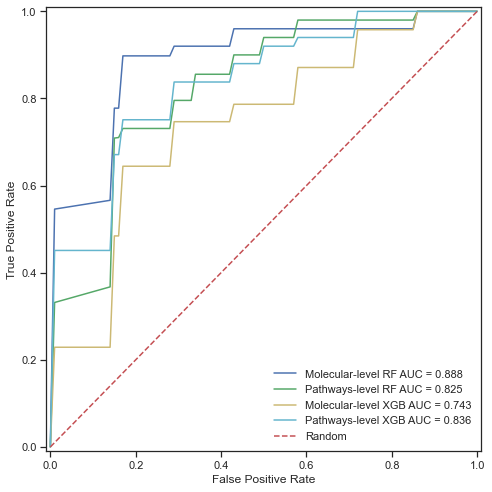

In [199]:
roc_auc = auc(base_fpr, mean_tprs) #Molecular-level
roc_auc_p = auc(base_fpr_p, mean_tprs_p) # Pathways-level GSEA
roc_auc_xgb = auc(base_fpr_xgb, mean_tprs_xgb) #Molecular-level
roc_auc_p_xgb = auc(base_fpr_p_xgb, mean_tprs_p_xgb) # Pathways-level GSEA

plt.figure(figsize=(7,7))
plt.style.use("seaborn-ticks")
plt.plot(base_fpr, mean_tprs, 'b', label=f"Molecular-level RF AUC = {roc_auc:.3f}")
plt.plot(base_fpr_p, mean_tprs_p, 'g', label=f"Pathways-level RF AUC = {roc_auc_p:.3f}")
plt.plot(base_fpr_xgb, mean_tprs_xgb, 'y', label=f"Molecular-level XGB AUC = {roc_auc_xgb:.3f}")
plt.plot(base_fpr_p_xgb, mean_tprs_p_xgb, 'c', label=f"Pathways-level XGB AUC = {roc_auc_p_xgb:.3f}")

#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
#plt.fill_between(base_fpr_p, tprs_lower_p, tprs_upper_p, color='grey', alpha=0.2)
#plt.fill_between(base_fpr_xgb, tprs_lower_xgb, tprs_upper_xgb, color='grey', alpha=0.2)
#plt.fill_between(base_fpr_p_xgb, tprs_lower_p_xgb, tprs_upper_p_xgb, color='grey', alpha=0.2)

plt.plot([0, 1], [0, 1],'r--', label='Random')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/roc_curve.png", dpi=300)
plt.show()

# differential pathway scores 

In [149]:
scores = ssgsea_results(key_modules_genes.iloc[:, :-2], pathways_present).T
de_res_path = t_tests(scores, key_modules_genes["Group"], "fdr_bh")
de_res_path.sort_values(by="P-adjust")["Pathway"][:30].map(pathway_names).tolist()

['Plasma lipoprotein remodeling',
 'HDL remodeling',
 'Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.',
 'Respiratory electron transport',
 'Interleukin-37 signaling',
 'Plasma lipoprotein assembly, remodeling, and clearance',
 'Bile acid and bile salt metabolism',
 'Synthesis of bile acids and bile salts',
 'Transcriptional activation of p53 responsive genes  ',
 'TP53 Regulates Transcription of Genes Involved in G1 Cell Cycle Arrest',
 'Transcriptional  activation of  cell cycle inhibitor p21 ',
 'Striated Muscle Contraction',
 'The citric acid (TCA) cycle and respiratory electron transport',
 'Synthesis of IP3 and IP4 in the cytosol',
 'Transcriptional regulation by the AP-2 (TFAP2) family of transcription factors',
 'PLC beta mediated events',
 'Signaling by NOTCH1 HD+PEST Domain Mutants in Cancer',
 'Degradation of cysteine and homocysteine',
 'Synthesis of bile acids and bile salts via 7alpha-hydroxycholesterol'

In [151]:
top30paths = de_res_path.sort_values(by="P-adjust")["Pathway"].tolist()[:30]
scores = scores.loc[:, top30paths]

top30paths = ['Plasma lipoprotein remodeling',
 'HDL remodeling',
 'Respiratory electron transport',
 'Interleukin-37 signaling',
 'Bile acid and bile salt metabolism',
 'Transcriptional activation of p53 responsive genes  ',
 'The citric acid (TCA) cycle and respiratory electron transport',
 'Synthesis of IP3 and IP4 in the cytosol',
 'Signaling by NOTCH1',
 'Glycogen metabolism']


data = scores
data.rename(columns=pathway_names, inplace=True)
data = data[top30paths].reset_index()


data = data.melt(id_vars = "index",
    var_name="Pathway", 
        value_name="Value").set_index('index')


data["Group"] = key_modules_genes["Group"]

df = data



C:\Users\brsha\anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Estimating ssGSEA scores for 879 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
879


<ipython-input-59-f1442aa4e613>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease.drop(['Target'], axis=1, inplace=True)
<ipython-input-59-f1442aa4e613>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctrl.drop(['Target'], axis=1, inplace=True)


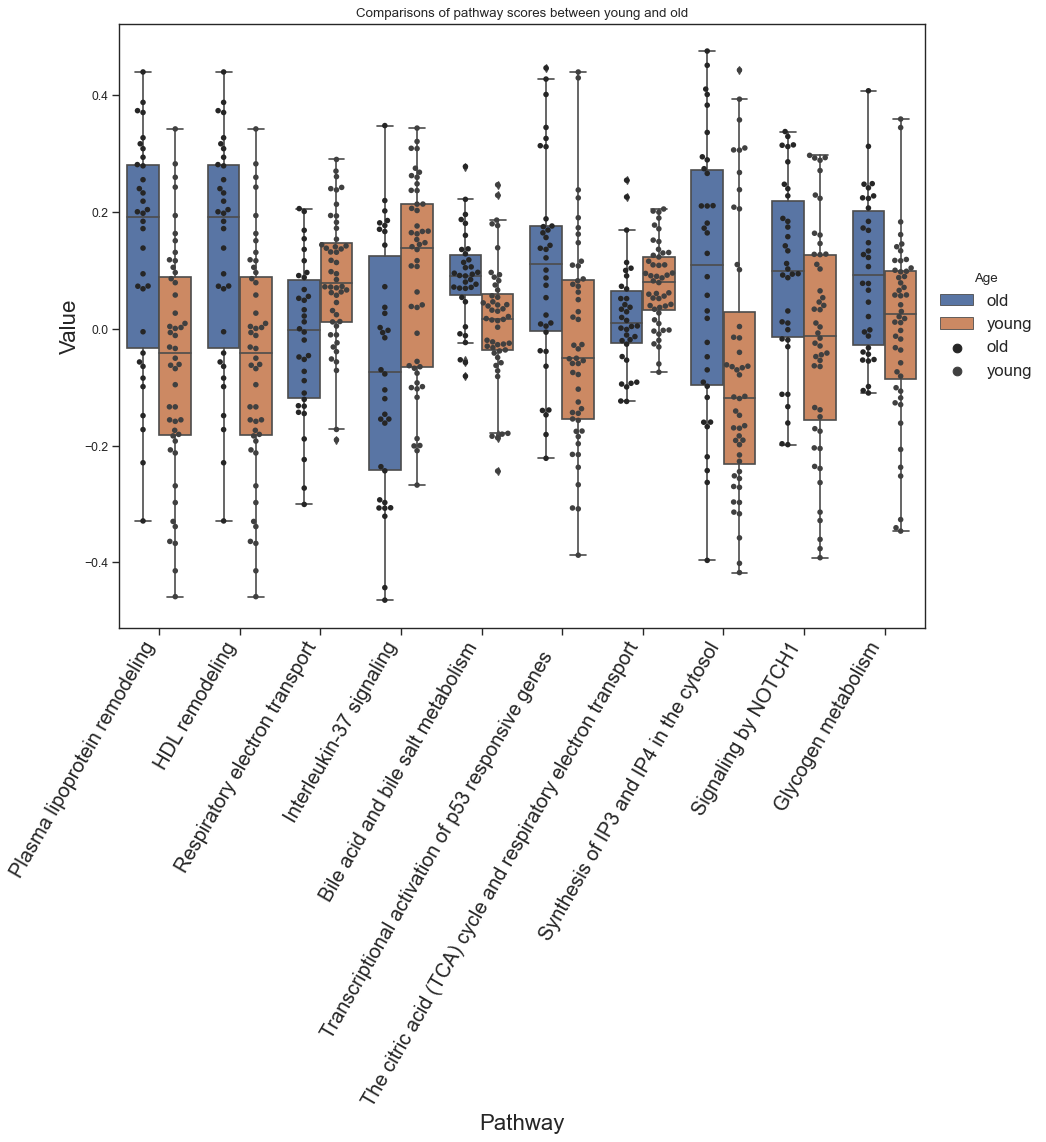

In [153]:

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)

#ax= sns.swarmplot(x='Pathway', y='Value', data=df, hue='Group', dodge=True)
sns.swarmplot(x='Pathway', y='Value', data=df, hue = 'Group', color=".25", dodge=True)

ax = sns.boxplot(x='Pathway', y='Value', data=df, hue='Group')

#sns.stripplot(x='Pathway', y='Value', data=df, color='black', size=3, jitter=1)

#for i in range(len(df['Group'].unique())-1):
#    plt.vlines(i+.5, 1, 10, linestyles='solid', colors='gray', alpha=0.2)

# Decoration
plt.title('Comparisons of pathway scores between young and old')
plt.legend(title='Age')
plt.xticks(rotation=60, ha='right', fontsize=18)
plt.legend(prop={'size': 15}, title = 'Age', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Pathway', fontsize=20)

plt.ylabel('Value', fontsize=20)

plt.savefig(f"plots/Comparisons of pathway scores between young and old.png", bbox_inches='tight', dpi=300)


plt.show()